# Health_care_prediction Mini project

실제 의료 데이터를 모방하여 설계된 데이터를 이용한 검사 결과 예측 프로그램입니다.<br>
데이터 출처 : 'https://www.kaggle.com/datasets/prasad22/healthcare-dataset'

In [1]:
# spark.stop()

In [2]:
from pyspark.sql import SparkSession
MAX_MEMORY = '8g'
spark = SparkSession.builder.appName("Health_cares")\
                .config('spark.driver.memory',MAX_MEMORY)\
                .config('spark.executor.memory', MAX_MEMORY)\
                .getOrCreate()

# 0. 라이브러리 불러오기 

In [52]:
# PySpark 기본
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, isnan, isnull, when, count, log1p, to_date, datediff

# 데이터 핸들링/변환
import pandas as pd
import numpy as np

# EDA/시각화 )
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가/해석
from sklearn.metrics import classification_report, confusion_matrix

# 시스템
import os
import sys

# 1. 데이터 불러오기

In [4]:
health_df = spark.read.csv('file:////home/jovyan/work/practice_virtual-environment/Healthcare_miniproject/healthcare_dataset.csv'
    , inferSchema=True, header=True)

In [5]:
health_df.toPandas()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,eLIZABeTH jaCkSOn,42,Female,O+,Asthma,2020-08-16,Joshua Jarvis,Jones-Thompson,Blue Cross,2650.714952,417,Elective,2020-09-15,Penicillin,Abnormal
55496,KYle pEREz,61,Female,AB-,Obesity,2020-01-23,Taylor Sullivan,Tucker-Moyer,Cigna,31457.797307,316,Elective,2020-02-01,Aspirin,Normal
55497,HEATher WaNG,38,Female,B+,Hypertension,2020-07-13,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,347,Urgent,2020-08-10,Ibuprofen,Abnormal
55498,JENniFER JOneS,43,Male,O-,Arthritis,2019-05-25,Kimberly Curry,"Jackson Todd and Castro,",Medicare,32451.092358,321,Elective,2019-05-31,Ibuprofen,Abnormal


# 2. EDA + 전처리 

In [6]:
health_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



Schema 용어 정리
이름 : Name<br>
나이 : Age<br>
성별 : Gender<br>
혈액형 : Blood Type<br>
건강 상태 : Medical Condition<br>
입원 날짜: Date of Admission<br>
의사: Doctor<br>
병원: Hospital<br>
보험 제공자: Insurance Provider <br>
청구 금액: Billing Amount<br>
병실 번호: Room Number<br>
입원 유형: Admission Type<br>
퇴원 날짜: Discharge Date<br>
약물: Medication<br>
검사 결과 : Test Results

검사 결과를 예측하는 프로젝트이기에 검사결과(Test Results)는 타겟으로 분리,<br>
이름, 의사, 병원, 보험제공자, 병실 번호는 검사결과에 <br>
유의미한 영향을 끼치지 못할 거라 판단, 삭제 예정 

In [7]:
# 개인 정보 또는 무의미한 컬럼 삭제
health_df = health_df.drop('Name', 'Doctor', 'Hospital' , 'Insurance Provider', 'Room Number')

In [8]:
health_df.describe().toPandas()

,summary,Age,Gender,Blood Type,Medical Condition,Billing Amount,Admission Type,Medication,Test Results
0,count,55500,55500,55500,55500,55500,55500,55500,55500
1,mean,51.53945945945946,None,None,None,25539.316097211744,None,None,None
2,stddev,19.602453808514394,None,None,None,14211.454430864422,None,None,None
3,min,13,Female,A+,Arthritis,-2008.4921398591305,Elective,Aspirin,Abnormal
4,max,89,Male,O-,Obesity,52764.276736469175,Urgent,Penicillin,Normal


In [9]:
# 결측치 확인(데이터의 양이 너무 크지 않기에 판다스로 변환해서 결측치 확인)
health_pd = health_df.toPandas()
print(health_pd.isnull().sum())

Age                  0
Gender               0
Blood Type           0
Medical Condition    0
Date of Admission    0
Billing Amount       0
Admission Type       0
Discharge Date       0
Medication           0
Test Results         0
dtype: int64


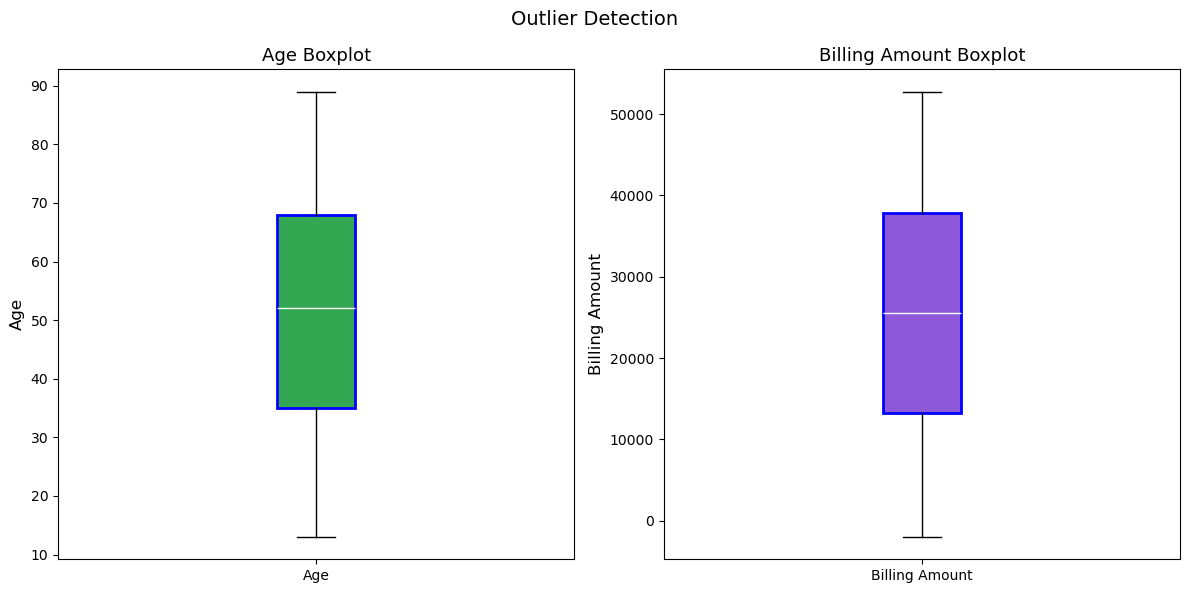

In [10]:
# 수치형 데이터('Age', 'Billing Amount') 이상치 처리 
age_data = health_pd['Age'].dropna().values
billing_data = health_pd['Billing Amount'].dropna().values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  

# Age 박스플롯(왼쪽)
axes[0].boxplot(age_data, patch_artist=True,
                boxprops=dict(facecolor='#32a852', color='blue', linewidth=2),
                medianprops=dict(color='white'))
axes[0].set_title('Age Boxplot', fontsize=13)
axes[0].set_ylabel('Age', fontsize=12)
axes[0].set_xticklabels(['Age'])

# Billing Amount 박스플롯(오른쪽)
axes[1].boxplot(billing_data, patch_artist=True,
                boxprops=dict(facecolor='#8e59d9', color='blue', linewidth=2),
                medianprops=dict(color='white'))
axes[1].set_title('Billing Amount Boxplot', fontsize=13)
axes[1].set_ylabel('Billing Amount', fontsize=12)
axes[1].set_xticklabels(['Billing Amount'])

fig.suptitle('Outlier Detection', fontsize=14)
fig.set_facecolor('white')
plt.tight_layout()
plt.show()


In [11]:
# Billin Amount 박스 플롯에서 음수값 존재 가능성 확인
minus_BA =  (health_pd['Billing Amount'] < 0).sum()
print(f'Billing Amount 음수 값 갯수 : {minus_BA}')

Billing Amount 음수 값 갯수 : 108


박스 플롯의 결과 Age 컬럼의 이상치는 없다고 판단<br>
하지만 Billing Amount의 경우 음수값이 나왔고,<br>
Age에 비해 스케일이 너무 크다고 판단<br>
음수 값의 갯수는 108개로 제거했을 때 모델 학습에 큰 영향을 끼치지 않을 것이라 판단 <br>
음수 값은 제거 후 로그 스케일을 통해 정규성 확보 예정 

In [12]:
# Billing Amount 전처리
health_df = health_df.filter(col('Billing Amount') >= 0)
health_df = health_df.withColumn('log_Billing_Amount', log1p(col('Billing Amount'))) 
print(' Billing Amount 전처리 확인 음수값 확인 ')
health_df.filter(col('Billing Amount')< 0 ).show()

 Billing Amount 전처리 확인 음수값 확인 
+---+------+----------+-----------------+-----------------+--------------+--------------+--------------+----------+------------+------------------+
|Age|Gender|Blood Type|Medical Condition|Date of Admission|Billing Amount|Admission Type|Discharge Date|Medication|Test Results|log_Billing_Amount|
+---+------+----------+-----------------+-----------------+--------------+--------------+--------------+----------+------------+------------------+
+---+------+----------+-----------------+-----------------+--------------+--------------+--------------+----------+------------+------------------+



In [13]:
# Medical Condition EDA
health_pd['Medical Condition'].value_counts(dropna=False)

Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64

Medical Condition 결과값 정리<br>
Arthritis : 관절염<br> 
Diabetes : 당뇨병<br>
Hypertension : 고혈압<br>    
Obesity : 비만<br>         
Cancer : 암<br>
Asthma : 천식

Medical Condition의 경우 원 - 핫 인코딩 예정  

In [14]:
# Admission Type EDA
health_pd['Admission Type'].value_counts(dropna=False) 

Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64

Admission Type 결과값 정리<br>
Elective : 선택적<br>
Urgent : 긴급<br>
Emergency : 응급

Admission Type의 경우 원 - 핫 인코딩 예정

In [15]:
# Medication EDA
health_pd['Medication'].value_counts(dropna=False)

Medication
Lipitor        11140
Ibuprofen      11127
Aspirin        11094
Paracetamol    11071
Penicillin     11068
Name: count, dtype: int64

Medication 결과값 정리<br>
Lipitor : 리피토<br>
Ibuprofen : 이부프로펜<br>
Aspirin : 아스피린<br>
Paracetamol : 파라세타몰<br>
Penicillin : 페니실린<Br>

Medication의 경우 원 - 핫 인코딩 예정

In [16]:
# 입원일과 퇴원일의 타입을 확인
print(health_df[['Date of Admission', 'Discharge Date']].dtypes)

[('Date of Admission', 'date'), ('Discharge Date', 'date')]


In [17]:
# Date of Admission, Discharge Date을 통해 총 입원 기간 컬럼 생성 
health_df = health_df.withColumn(
    'Total_Period',
    datediff(col('Discharge Date'), col('Date of Admission'))
)

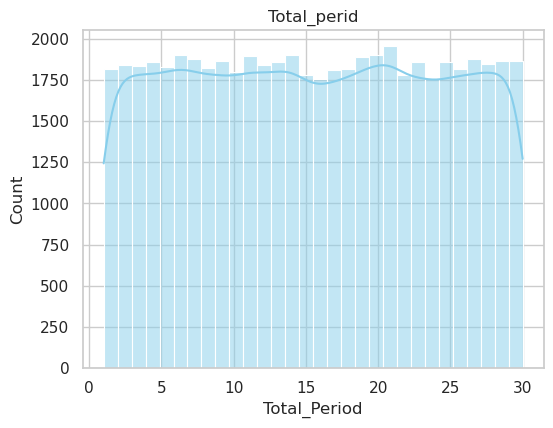

In [18]:
# total_period EDA
health_pd1 = health_df.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 3)
sns.histplot(health_pd1["Total_Period"], bins=30, kde=True, color="skyblue")
plt.title("Total_perid")


plt.tight_layout()
plt.show()

나이, 가격, 원핫인코딩이 예정되어 있는 점을 고려했을 때 Total_Period의 값의 규모가 크다고 판단,<br>
로그 변환을 실시 

In [19]:
# Total_Period로그 변환 전처리
health_df = health_df.withColumn('log_Total_Period',log1p(col('Total_Period')))

In [20]:
# Blood Type과 Gender EDA
health_df.groupBy('Gender').count().show()
health_df.groupBy('Blood Type').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|27666|
|  Male|27726|
+------+-----+

+----------+-----+
|Blood Type|count|
+----------+-----+
|       AB+| 6937|
|        O+| 6905|
|       AB-| 6929|
|        A-| 6953|
|        O-| 6860|
|        B+| 6936|
|        A+| 6939|
|        B-| 6933|
+----------+-----+



성별과 혈액형의 경우 원 - 핫 인코딩 적용 예정 

In [21]:
# 타겟인 Test Results EDA
health_pd1['Test Results'].value_counts(dropna=False)

Test Results
Abnormal        18589
Normal          18488
Inconclusive    18315
Name: count, dtype: int64

타겟 변수인 Test Results EDA 결과 라벨 인코딩이 실시 예정

In [22]:
indexer = StringIndexer(inputCol='Test Results', outputCol='Test_Results_idx', handleInvalid='keep')
health_df = indexer.fit(health_df).transform(health_df)

# 결과 확인
health_df.select('Test Results', 'Test_Results_idx').show(5)

+------------+----------------+
|Test Results|Test_Results_idx|
+------------+----------------+
|      Normal|             1.0|
|Inconclusive|             2.0|
|      Normal|             1.0|
|    Abnormal|             0.0|
|    Abnormal|             0.0|
+------------+----------------+
only showing top 5 rows



In [24]:
# Medical Condition, Admission Type, Medication 전처리 원 - 핫 인코딩 파이프라인

categorical_cols = ['Medical Condition', 'Admission Type', 'Medication', 'Gender', 'Blood Type']

indexers = [
    StringIndexer(inputCol=col, outputCol=col + '_idx', handleInvalid='keep')
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=col + '_idx', outputCol=col + '_OHE')
    for col in categorical_cols
]

# 파이프라인 생성
pipeline = Pipeline(stages=indexers + encoders)

# 데이터에 fit & transform (health_df는 기존 DataFrame)
pipeline_model = pipeline.fit(health_df)
encoded_df = pipeline_model.transform(health_df)

In [25]:
# 결과 확인
encoded_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)
 |-- log_Billing_Amount: double (nullable = true)
 |-- Total_Period: integer (nullable = true)
 |-- log_Total_Period: double (nullable = true)
 |-- Test_Results_idx: double (nullable = false)
 |-- Medical Condition_idx: double (nullable = false)
 |-- Admission Type_idx: double (nullable = false)
 |-- Medication_idx: double (nullable = false)
 |-- Gender_idx: double (nullable = false)
 |-- Blood Type_idx: double (nullable = false)
 |-- Medical Condition_OHE: vector (nullable = true)
 |-- Admission Type_OHE: vector (nullable = true)
 |-- Medication_OHE: vec

사용 컬럼들 총 정리<br>
    'Age', 'log_Billing_Amount', 'log_Total_Period', <br>
    'Medical Condition_OHE', 'Admission Type_OHE', 'Medication_OHE',<br>
    'Gender_OHE','Blood Type_OHE'

In [26]:
# VectorAssembler, StandardScaler 전처리 
numeric_features = ['Age', 'log_Billing_Amount', 'log_Total_Period']
assembler_num = VectorAssembler(inputCols=numeric_features, outputCol='num_features')
scaler = StandardScaler(inputCol='num_features', outputCol='num_features_scaled')

# features 조합
assemblered = VectorAssembler(
    inputCols=['num_features_scaled', 'Medical Condition_OHE', 'Admission Type_OHE', 'Medication_OHE', 'Gender_OHE', 'Blood Type_OHE'],
    outputCol='features'
)

In [31]:
# stages 리스트 추가
stages = indexers + encoders + [assembler_num, scaler, assemblered]

# 3. 모델링

In [32]:
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(health_df)
final_df = pipeline_model.transform(health_df)

In [34]:
# 학습에 불필요한 컬럼 확인
final_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)
 |-- log_Billing_Amount: double (nullable = true)
 |-- Total_Period: integer (nullable = true)
 |-- log_Total_Period: double (nullable = true)
 |-- Test_Results_idx: double (nullable = false)
 |-- Medical Condition_idx: double (nullable = false)
 |-- Admission Type_idx: double (nullable = false)
 |-- Medication_idx: double (nullable = false)
 |-- Gender_idx: double (nullable = false)
 |-- Blood Type_idx: double (nullable = false)
 |-- Medical Condition_OHE: vector (nullable = true)
 |-- Admission Type_OHE: vector (nullable = true)
 |-- Medication_OHE: vec

In [35]:
final_df = final_df.select('features', 'Test_Results_idx')

In [36]:
final_df.select('features').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------+
|features                                                                                                 |
+---------------------------------------------------------------------------------------------------------+
|(27,[0,1,2,7,10,15,17,23],[1.5304525425594289,11.655743438591237,1.5417772235329068,1.0,1.0,1.0,1.0,1.0])|
|(27,[0,1,2,6,11,13,17,20],[3.1629352546228198,12.341195477165444,2.7308632697821142,1.0,1.0,1.0,1.0,1.0])|
|(27,[0,1,2,6,11,14,18,19],[3.877146441150553,12.121913967296086,3.891012494822811,1.0,1.0,1.0,1.0,1.0])  |
|(27,[0,1,2,4,9,13,18,25],[1.428422373055467,12.482550576488512,4.8192099363801,1.0,1.0,1.0,1.0,1.0])     |
|(27,[0,1,2,7,10,16,18,21],[2.1936486443351817,11.323176512601892,4.272640493315021,1.0,1.0,1.0,1.0,1.0]) |
+---------------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [37]:
train_data, test_data = final_df.randomSplit([0.8,0.2], seed=42)

### LogisticRegression 모델

In [41]:
lr = LogisticRegression(featuresCol='features', labelCol='Test_Results_idx')
lr_model = lr.fit(train_data)
lr_model_v = lr_model.transform(test_data)

In [44]:
# Accuracy 계산
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',   
    predictionCol='prediction',    
    metricName='accuracy'           
)
accuracy = accuracy_evaluator.evaluate(lr_model_v)

# F1-score 계산
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',
    predictionCol='prediction',
    metricName='f1'                
)
f1_score = f1_evaluator.evaluate(lr_model_v)

print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"F1-score (macro): {f1_score:.4f}")

정확도 (Accuracy): 0.3329
F1-score (macro): 0.3309


### RandomForestClassifier 모델

In [46]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Test_Results_idx')
rf_model = rf.fit(train_data)
rf_model_v = rf_model.transform(test_data)

In [47]:
# Accuracy 계산
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',   
    predictionCol='prediction',    
    metricName='accuracy'           
)
accuracy = accuracy_evaluator.evaluate(rf_model_v)

# F1-score 계산
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',
    predictionCol='prediction',
    metricName='f1'                
)
f1_score = f1_evaluator.evaluate(rf_model_v)

print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"F1-score (macro): {f1_score:.4f}")

정확도 (Accuracy): 0.3344
F1-score (macro): 0.3271


### DecisionTreeClassifier 모델

In [53]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Test_Results_idx')
dt_model = dt.fit(train_data)
dt_model_v = dt_model.transform(test_data)

In [54]:
# Accuracy 계산
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',   
    predictionCol='prediction',    
    metricName='accuracy'           
)
accuracy = accuracy_evaluator.evaluate(dt_model_v)

# F1-score 계산
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='Test_Results_idx',
    predictionCol='prediction',
    metricName='f1'                
)
f1_score = f1_evaluator.evaluate(dt_model_v)

print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"F1-score (macro): {f1_score:.4f}")

정확도 (Accuracy): 0.3339
F1-score (macro): 0.3051
